In [3]:
from google.colab import drive
drive.mount('/content/drive')

!pwd
import os
os.chdir('/content/drive/MyDrive/airbnb-amenity-detection/')
!pwd

Mounted at /content/drive
/content
/content/drive/MyDrive/airbnb-amenity-detection


# Detectron2 Model Tuning

This notebook picks a Detectron2 model from the model zoo and tunes its hyperparameters on it on a subset of the data (10% of training and 10% of combined validation/test data). 

The model chosen is from the Weights & Biases runs done in previous experiments. 

Original Detectron2 tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

+

<img src="https://i.imgur.com/1oTyk79.png" width="500">


# Import Dependencies

In [ ]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
# !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# install detectron2:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

# WandB - Install the W&B library
# !pip install wandb -q

# Need awscli to download images from AWS (labels come from GCP)
# !pip install awscli

print("#### Versions: ####")
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

#### Versions: ####
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
import logging
import os
import argparse
from collections import OrderedDict
import pandas as pd
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import ( ### Changes from original, I don't need all the different evaluators
    COCOEvaluator,
    DatasetEvaluators,
    inference_on_dataset,
    print_csv_format
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
# Not sure what these do but they may help to track experiments
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter
)

from detectron2.utils.visualizer import Visualizer

# Setup logger
logger = logging.getLogger("detectron2")

In [ ]:
# import some common libraries
import cv2
import json
import random
import os
import pandas as pd
import numpy as np
#from google.colab.patches import cv2_imshow
from tqdm import tqdm

# wandb - Import weight's & biases
import wandb

import torch, torchvision
print(torch.__version__)
!gcc --version
# opencv is pre-installed on colab

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


1.4.0+cu100
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# What GPU are we using?
!nvidia-smi

Wed Feb  2 02:46:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # wandb - Login to wandb account so all metrics can be logged
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Initialize Weights & Biases
import wandb
wandb.init(project="airbnb-amenity-detection", 
           sync_tensorboard=True)

wandb: Currently logged in as: parthamehta (use `wandb login --relogin` to force relogin)


# Setup paths and target classes

TODO - add annotations

In [ ]:
valid_path = "validation"
train_path = "train"
test_path = "test"
train_10_path = "train_10"
val_test_10_path = "val_test_10"
val_test_path = "val_test"

In [ ]:
# Classes of amenities Airbnb mostly cares about
subset = ['Toilet',
         'Swimming pool',
         'Bed',
         'Billiard table',
         'Sink',
         'Fountain',
         'Oven',
         'Ceiling fan',
         'Television',
         'Microwave oven',
         'Gas stove',
         'Refrigerator',
         'Kitchen & dining room table',
         'Washing machine',
         'Bathtub',
         'Stairs',
         'Fireplace',
         'Pillow',
         'Mirror',
         'Shower',
         'Couch',
         'Countertop',
         'Coffeemaker',
         'Dishwasher',
         'Sofa bed',
         'Tree house',
         'Towel',
         'Porch',
         'Wine rack',
         'Jacuzzi']

# Put target classes in alphabetical order (required for the labels being generated)
subset.sort()

In [ ]:
subset

['Bathtub',
 'Bed',
 'Billiard table',
 'Ceiling fan',
 'Coffeemaker',
 'Couch',
 'Countertop',
 'Dishwasher',
 'Fireplace',
 'Fountain',
 'Gas stove',
 'Jacuzzi',
 'Kitchen & dining room table',
 'Microwave oven',
 'Mirror',
 'Oven',
 'Pillow',
 'Porch',
 'Refrigerator',
 'Shower',
 'Sink',
 'Sofa bed',
 'Stairs',
 'Swimming pool',
 'Television',
 'Toilet',
 'Towel',
 'Tree house',
 'Washing machine',
 'Wine rack']

## Import premade labels

In [ ]:
%%time
from preprocessing import load_json_labels

# These require .JSON files to be made in train/validation images folders
val_img_dicts = load_json_labels(val_test_path)
train_img_dicts = load_json_labels(train_path)

CPU times: user 491 ms, sys: 60.5 ms, total: 551 ms
Wall time: 7.76 s


In [ ]:
val_img_dicts[0], train_img_dicts[1]

({'annotations': [{'bbox': [0.0, 1.0, 1024.0, 768.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 24}],
  'file_name': 'val_test/007f71665b0812a7.jpg',
  'height': 768,
  'image_id': 0,
  'width': 1024},
 {'annotations': [{'bbox': [13.0, 703.0, 682.0, 995.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 22}],
  'file_name': 'train/b8f0b3b3b113b57b.jpg',
  'height': 1024,
  'image_id': 1,
  'width': 683})

In [ ]:
!ls

00-open-images-data-manipulation.ipynb
01-open-images-data-manipulation.ipynb
02-open-images-data-manipulation.ipynb
03-open-images-data-manipulation.ipynb
04-detectron2-small-model-building.ipynb
05-detectron2-experiment-tracking.ipynb
06-detectron2-experiment-tracking.ipynb
07-creating-detectron2-labels-locally.ipynb
08-GCP-data-manipulation.ipynb
09-detectron2-model-tuning.ipynb
10-detectron2-eval-and-inference.ipynb
aws
awscliv2.zip
bjj.mp4
class-descriptions-boxable.csv
cmaker-bathtub-treehouse-train
cmaker-bathtub-treehouse-validation
custom_images
data
detectron2
downloadOI_old_used_to_download_images_as_well_as_create_label_files_in_form_of_text.py
downloadOI.py
explorer_notebook.ipynb
LinkedIn_Profile-2.jpeg
LinkedIn_Profile.jpeg
OIDv4_ToolKit
output
preprocessing.py
__pycache__
README.md
README_tutorials.md
subset-train-10-annotations.csv
subset-train-annotations.csv
subset-valid-annotations.csv
subset-val-test-10-annotations.csv
test
test-annotations-bbox.csv
test-backup
tes

# Train on a custom dataset

## plain_train_net.py 

I'm going to write out the plain_train_net.py script verbatim to see what it's doing.

https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py

I'll leave notes and change it where I need to.

## Register dataset
Before I can train a model I've got to register a dataset in Detectron2 style: https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset

This will leverage my preprocessing functions.

**Note:** Be sure to update the config for new datasets: https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets

In [ ]:
# Setup training and validation data paths
train_10_path, val_test_10_path, subset

('train_10',
 'val_test_10',
 ['Bathtub',
  'Bed',
  'Billiard table',
  'Ceiling fan',
  'Coffeemaker',
  'Couch',
  'Countertop',
  'Dishwasher',
  'Fireplace',
  'Fountain',
  'Gas stove',
  'Jacuzzi',
  'Kitchen & dining room table',
  'Microwave oven',
  'Mirror',
  'Oven',
  'Pillow',
  'Porch',
  'Refrigerator',
  'Shower',
  'Sink',
  'Sofa bed',
  'Stairs',
  'Swimming pool',
  'Television',
  'Toilet',
  'Towel',
  'Tree house',
  'Washing machine',
  'Wine rack'])

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

def register_datasets(train_path, valid_path=None, target_classes=None):
  """
  Registers a Detectron2 style dataset from training paths.

  Params
  ------
  train_path (str) : pathname to training data containing training images
  valid_path (str) : pathname to validation data containing validation images
  """
  # TODO - update to accept any kind of path, e.g. not only coffeemaker, maybe could take a dict as input?
  # E.g. {"training": "path/to/training",
  #          "valid": "path/to/valid"}
  for d in [train_path, valid_path]:
    dataset_name = d.split("/")[-1]
    print("Registering: {}".format(dataset_name))
    DatasetCatalog.register(dataset_name, lambda d=d: load_json_labels(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=target_classes)
  return MetadataCatalog.get(dataset_name)

In [ ]:
metadata = register_datasets(train_path=train_path,
                             valid_path=val_test_path,
                             target_classes=subset)

Registering: train
Registering: val_test


In [ ]:
metadata

Metadata(name='val_test', thing_classes=['Bathtub', 'Bed', 'Billiard table', 'Ceiling fan', 'Coffeemaker', 'Couch', 'Countertop', 'Dishwasher', 'Fireplace', 'Fountain', 'Gas stove', 'Jacuzzi', 'Kitchen & dining room table', 'Microwave oven', 'Mirror', 'Oven', 'Pillow', 'Porch', 'Refrigerator', 'Shower', 'Sink', 'Sofa bed', 'Stairs', 'Swimming pool', 'Television', 'Toilet', 'Towel', 'Tree house', 'Washing machine', 'Wine rack'])

In [ ]:
# # Check registered dataset
# DatasetCatalog._REGISTERED

In [ ]:
# # Remove a certain registered dataset if needed:
# DatasetCatalog._REGISTERED.pop()

## TODO - Visualize dataset

Once you've got a dataset registered with Detectron2 it's a good idea to be able to visualize an image.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_sample(data_dicts, metadata, n=1):
  """
  Show n random samples from data_dicts, label with metadata.
  """
  for d in random.sample(data_dicts, n):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=metadata, 
                            scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    
#     # Try plot with cv2 in Jupyter... (doesn't work)
#     cv2.imshow('image', vis.get_image()[:, :, ::-1])
#     cv2.waitKey(0) 
#     cv2.destroyWindow('image')
    
    # Try plot with matplotlib (works)
    plt.figure(figsize=(10, 6))
    plt.imshow(vis.get_image()) #[:, :, ::-1])
    plt.xticks([])
    plt.yticks([])
    plt.show()

{'file_name': 'val_test/d9d569d62f19e52a.jpg', 'image_id': 1434, 'height': 681, 'width': 1024, 'annotations': [{'bbox': [0.0, 240.0, 1024.0, 681.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 23}]}


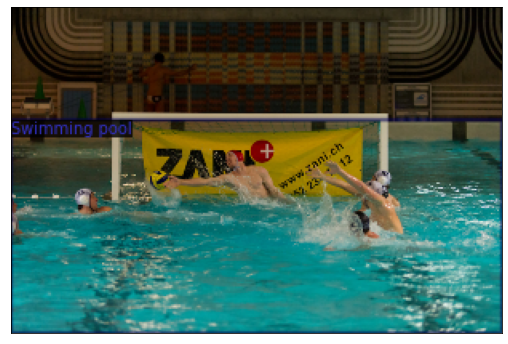

{'file_name': 'val_test/3836458f0450bf64.jpg', 'image_id': 2123, 'height': 685, 'width': 1024, 'annotations': [{'bbox': [133.0, 350.0, 388.0, 501.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 20}]}


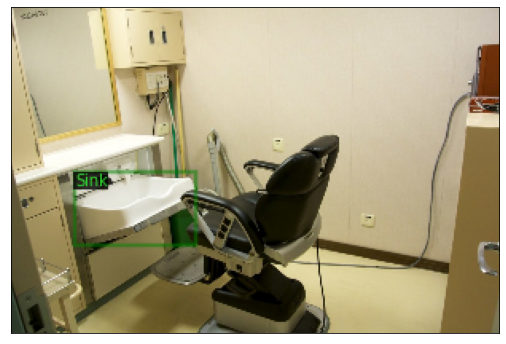

In [ ]:
visualize_sample(val_img_dicts, 
                 metadata, 
                 n=2)

## Train

The following code is original training code from the Detectron2 example notebook but I think we can make it better/suit our problem.

In [ ]:
# # Example setup of default config
# default_config = get_cfg()
# default_config.DATASETS.TRAIN = ("my-training-data",)
# default_config.DATASETS
# # Set cfg.TEST.EVAL_PERIOD to something to have an evaluation be run every X iterations
# default_config.TEST

In [ ]:
# Changed from original: Create evaluator for COCOEvaluator only 
# Since we are only using bounding boxes to begin with, our evaluator can be simple COCO style
def get_evaluator(cfg, dataset_name, output_folder=None):
  """
  Create a COCOEvaluator
  """
  if output_folder is None:
    output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
  evaluator = COCOEvaluator(
      dataset_name=dataset_name,
      cfg=cfg,
      distributed=False,
      output_dir=output_folder
  )
  return evaluator

In [ ]:
# Create testing function
def do_test(cfg, model):
  results = OrderedDict()
  for dataset_name in cfg.DATASETS.TEST:
    data_loader = build_detection_test_loader(cfg, dataset_name)
    # Create the evaluator
    evaluator = get_evaluator(
        cfg, 
        dataset_name,
        output_folder=os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
    )
    # Make inference on dataset
    results_i = inference_on_dataset(model,
                                     data_loader,
                                     evaluator)
    # Update results dictionary
    results[dataset_name] = results_i

    print("### Returning results_i...")
    #print(results_i)
    #print(f"### Average Precision: {results_i['AP']}")
    # Let's get some communication happening
    if comm.is_main_process():
      logger.info("Evaluation results for {} in csv format:".format(dataset_name))
      ## wandb.log()? TODO/NOTE: This may be something Weights & Biases can track
      #print("### Calculating results...")
      print_csv_format(results_i)
    
    # Check to see length of results
    if len(results) == 1:
      results = list(results.values())[0]
    #print("### Returning results...")
    #print(results)

    # TODO : log results_i dict with different parameters
    print("### Saving results to Weights & Biases...")
    wandb.log(results_i)

    return results

Source code for Checkpointer: https://detectron2.readthedocs.io/_modules/fvcore/common/checkpoint.html

Maybe information from the Checkpointers can be saved to Weights & Biases? Or at least used to track in my own tracking.

In [ ]:
# Create training function
def do_train(cfg, model, resume=False):
  # Set model to training mode
  model.train()
  # Create optimizer from config file (returns torch.nn.optimizer.Optimizer)
  optimizer = build_optimizer(cfg, model)
  # Create scheduler for learning rate (returns torch.optim.lr._LR_scheduler)
  scheduler = build_lr_scheduler(cfg, optimizer)
  print(f"Scheduler: {scheduler}")

  # Create checkpointer
  checkpointer = DetectionCheckpointer(
      model, save_dir=cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
  )

  # Create start iteration (refernces checkpointer) - https://detectron2.readthedocs.io/modules/checkpoint.html#detectron2.checkpoint.Checkpointer.resume_or_load
  start_iter = (
      # This can be 0
      checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, # Use predefined model weights (pretrained model)
                                  resume=resume).get("iteration", -1) + 1
  )
  # Set max number of iterations
  max_iter = cfg.SOLVER.MAX_ITER

  # Create periodiccheckpoint
  periodic_checkpointer = PeriodicCheckpointer(checkpointer=checkpointer,
                                               # How often to make checkpoints?
                                               period=cfg.SOLVER.CHECKPOINT_PERIOD,
                                               max_iter=max_iter)
  
  # Create writers (for saving checkpoints?)
  writers = (
      [
       # Print out common metrics such as iteration time, ETA, memory, all losses, learning rate
       CommonMetricPrinter(max_iter=max_iter),
       # Write scalars to a JSON file such as loss values, time and more
       JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
       # Write all scalars such as loss values to a TensorBoard file for easy visualization
       TensorboardXWriter(cfg.OUTPUT_DIR),
      ]
      if comm.is_main_process()
      else []
  )

  ### Original note from script: ###
  # compared to "train_net.py", we do not support accurate timing and precise BN
  # here, because they are not trivial to implement

  # Build a training data loader based off the training dataset name in the config
  data_loader = build_detection_train_loader(cfg)

  # Start logging
  logger.info("Starting training from iteration {}".format(start_iter))

  # Store events
  with EventStorage(start_iter) as storage:
    # Loop through zipped data loader and iteration
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
      iteration = iteration + 1
      storage.step() # update stroage with step - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.step

      # Create loss dictionary by trying to model data
      loss_dict = model(data)
      losses = sum(loss_dict.values())
      # Are losses infinite? If so, something is wrong
      assert torch.isfinite(losses).all(), loss_dict

      # TODO - Not quite sure what's happening here
      loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
      # Sum up losses
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())
      
      # # TODO: wandb.log()? log the losses
      # wandb.log({
      #     "Total loss": losses_reduced
      # })

      # Update storage
      if comm.is_main_process():
        # Store informate in storage - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.put_scalars
        storage.put_scalars(total_loss=losses_reduced,
                            **loss_dict_reduced)
      
      # Start doing PyTorch things
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
      # Add learning rate to storage information
      storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
      # This is required for your learning rate to change!!!! (not having this meant my learning rate was staying at 0)
      scheduler.step()

      # Perform evaluation?
      if (
          cfg.TEST.EVAL_PERIOD > 0
          and iteration % cfg.TEST.EVAL_PERIOD == 0
          and iteration != max_iter
      ):
          do_test(cfg, model)
          # TODO - compared to "train_net.py", the test results are not dumped to EventStorage
          comm.synchronize()
      
      # Log different metrics with writers
      if iteration - start_iter > 5 and (iteration % 20 == 0 or iteration == max_iter):
        for writer in writers:
          writer.write()
      
      # Update the periodic_checkpointer
      periodic_checkpointer.step(iteration)

In [ ]:
# Create setup function
def setup(args):
  """
  Create configs and perform basic setups.
  """
  cfg = get_cfg()
  cfg.merge_from_file(args.config_file) # This will take some kind of model.yaml file
  cfg.merge_from_list(args.opts)
  cfg.freeze()
  default_setup(
      cfg, args
  ) # this logs the config and arguments passed to the command line to the output file

  # Load config YAML as dict
  cfg_yaml = cfg.load_yaml_with_base(os.path.join(cfg.OUTPUT_DIR, "config.yaml"))

  # default_config = get_cfg()
  # default_config_loaded = default_config.load_yaml_with_base("output/config.yaml")
  # default_config_loaded

  # TODO: turn config into YAML and save to weights & biases
  # TODO: Init wandb and add configs
  # Setup a new weights & biases run every time we run the setup() function
  wandb.init(project="airbnb-amenity-detection", 
             sync_tensorboard=True)
  
  #print("### Printing config_yaml file to go into Weights & Biases")
  #print(cfg_yaml)
  wandb.config.update(cfg_yaml)

  return cfg

In [ ]:
# Create main function
def main(args):
  
  # Create the config file
  cfg = setup(args)

  # Build the model
  model = build_model(cfg)
  
  # Log what's going on
  logger.info("Model:\n{}".format(model))

  # TODO: Fix this (if it doesn't work)
  #wandb.watch(model, log="all")

  # Only do evaluation if the args say so
  if args.eval_only:
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    return do_test(cfg, model)

  # Do distributed training? (depends on number of GPUs available)
  distributed = comm.get_world_size() > 1
  print(f"Using distributed: {distributed}")
#   torch.distributed.init_process_group("nccl")
  #distributed = torch.distributed.is_available()
  if distributed:
    # Put the model on multiple devices if available
    model = DistributedDataParallel(
        model, 
        device_ids=[comm.get_local_rank()], 
        broadcast_buffers=False
    )

  # Train the model
  do_train(cfg, model)
  # TODO - May want to evaluate in a different step?
  return do_test(cfg, model)

In [ ]:
comm.get_local_rank()

0

In [ ]:
comm.get_world_size()

1

In [ ]:
comm.get_rank()

0

In [ ]:
torch.cuda.is_available()

True

In [ ]:
comm.get_world_size() > 1

False

In [ ]:
torch.distributed.is_available()

True

In [ ]:
import torch.distributed as dist
dist.is_available()

True

In [ ]:
distributed = torch.distributed.is_available()
distributed

True

## TODO: Setup different experiments for `models_to_try`

Let's use a MAX_ITER of ~30 whilst we're building a small model.

We'll also change some defaults:
* `SOLVER.IMS_PER_BATCH` = 16 -> 2 (lower for memory issues)
* `DATALOADER.NUM_WORKERS` = 4 -> 2 (lower for memory issues)

These lowering settings are based on the example Detectron2 tutorial notebook (which runs in Colab), we can update them later once we figure out what resources we're using.

See this post for an example of resource use: https://lambdalabs.com/blog/weights-and-bias-gpu-cpu-utilization/

In [ ]:
# Different models I'd like to try - https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
models_to_try = {
    #"RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
    #"RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
}

In [ ]:
# Setup arg parser
parser = default_argument_parser() # default in Detectron2

In [ ]:
# Setup different weights and config files to try
weights = []
configs = []
for k, v in models_to_try.items():
  model = models_to_try[k]
  model_weights = model_zoo.get_checkpoint_url(model)
  weights.append(model_weights)
  config_file = model_zoo.get_config_file(model)
  configs.append(config_file)
weights_configs = dict(zip(weights, configs))
weights_configs

{'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl': '/usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml'}

In [ ]:
torch.cuda.device_count()

1

In [ ]:
# Setup different arg strings to pass to main() 
workers = 2
ims_per_batch = 2
# For transfer learning, divide LR by 10
lr = 0.000125 # divide LR by 8 according to linear scheduling rate: https://github.com/facebookresearch/detectron2/blob/master/configs/Base-RetinaNet.yaml
max_iter = 180000 # for a full model this should be in accordance with the linear scaling (e.g. increased by 8x from default)
seed = 33
num_classes = len(subset)
warmup_iters = 2000 # how many iterations does it take to warmup to the learning rate
eval_period = 30000 # how often to evaluate the data (number of steps, usual is to do at the end of all training)
steps = (120000, 160000) # when the learning rate should be decreased
num_gpus = torch.cuda.device_count()
dist_url = "auto"
eval_only = True
#output_dir = "/content/drive/MyDrive/airbnb-amenity-detection/output" # where do you want the outputs to be saved?

arg_strings = []
for weights, config in weights_configs.items():
  # removed model weights
  arg_string = f"--config-file {config} \
                --num-gpus {num_gpus} \
                --dist-url {dist_url} \
                MODEL.WEIGHTS {weights} \
                DATASETS.TRAIN ('train',) \
                DATASETS.TEST ('val_test',) \
                DATALOADER.NUM_WORKERS {workers} \
                SOLVER.IMS_PER_BATCH {ims_per_batch} \
                SOLVER.BASE_LR {lr} \
                SOLVER.MAX_ITER {max_iter} \
                SOLVER.WARMUP_ITERS {warmup_iters} \
                SEED {seed} \
                TEST.EVAL_PERIOD {eval_period} \
                SOLVER.STEPS {steps} \
                MODEL.RETINANET.NUM_CLASSES {num_classes}".split()
  arg_strings.append(arg_string)

In [ ]:
arg_strings[0]

['--config-file',
 '/usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml',
 '--num-gpus',
 '1',
 '--dist-url',
 'auto',
 'MODEL.WEIGHTS',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl',
 'DATASETS.TRAIN',
 "('train',)",
 'DATASETS.TEST',
 "('val_test',)",
 'DATALOADER.NUM_WORKERS',
 '2',
 'SOLVER.IMS_PER_BATCH',
 '2',
 'SOLVER.BASE_LR',
 '0.000125',
 'SOLVER.MAX_ITER',
 '180000',
 'SOLVER.WARMUP_ITERS',
 '2000',
 'SEED',
 '33',
 'TEST.EVAL_PERIOD',
 '30000',
 'SOLVER.STEPS',
 '(120000,',
 '160000)',
 'MODEL.RETINANET.NUM_CLASSES',
 '30']

In [6]:
!pip install streamlit

     |████████████████████████████████| 9.7 MB 13.0 MB/s 
     |████████████████████████████████| 180 kB 72.7 MB/s 
     |████████████████████████████████| 76 kB 6.8 MB/s 
     |████████████████████████████████| 164 kB 80.1 MB/s 
     |████████████████████████████████| 111 kB 65.6 MB/s 
     |████████████████████████████████| 4.3 MB 57.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 128 kB 75.3 MB/s 
     |████████████████████████████████| 792 kB 64.4 MB/s 
     |████████████████████████████████| 375 kB 74.8 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=30c259e693a5dffe5d41df47a658d9203a07e5d82d99e65a72dabefc1c83b362
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      

In [ ]:
arg_strings[0] = ['--config-file',
 '/content/drive/MyDrive/airbnb-amenity-detection/detectron2/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml',
 '--num-gpus',
 '1',
 '--dist-url',
 'auto',
 'MODEL.WEIGHTS',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl',
 'DATASETS.TRAIN',
 "('train',)",
 'DATASETS.TEST',
 "('val_test',)",
 'DATALOADER.NUM_WORKERS',
 '2',
 'SOLVER.IMS_PER_BATCH',
 '2',
 'SOLVER.BASE_LR',
 '0.000125',
 'SOLVER.MAX_ITER',
 '180000',
 'SOLVER.WARMUP_ITERS',
 '2000',
 'SEED',
 '33',
 'TEST.EVAL_PERIOD',
 '30000',
 'SOLVER.STEPS',
 '(120000, 160000)',
 'MODEL.RETINANET.NUM_CLASSES',
 '30']

In [ ]:
# Create different arg parsers
arg_list = []
for arg_string in arg_strings:
  args = parser.parse_args(arg_string)
  print(args)
  arg_list.append(args)

Namespace(config_file='/content/drive/MyDrive/airbnb-amenity-detection/detectron2/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml', dist_url='auto', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl', 'DATASETS.TRAIN', "('train',)", 'DATASETS.TEST', "('val_test',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '2', 'SOLVER.BASE_LR', '0.000125', 'SOLVER.MAX_ITER', '180000', 'SOLVER.WARMUP_ITERS', '2000', 'SEED', '33', 'TEST.EVAL_PERIOD', '30000', 'SOLVER.STEPS', '(120000, 160000)', 'MODEL.RETINANET.NUM_CLASSES', '30'], resume=False)


In [ ]:
!nvidia-smi

Tue Feb  1 04:55:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
args

Namespace(config_file='/content/drive/MyDrive/airbnb-amenity-detection/detectron2/configs/COCO-Detection/retinanet_R_101_FPN_3x.yaml', dist_url='auto', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl', 'DATASETS.TRAIN', "('train',)", 'DATASETS.TEST', "('val_test',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '2', 'SOLVER.BASE_LR', '0.000125', 'SOLVER.MAX_ITER', '180000', 'SOLVER.WARMUP_ITERS', '2000', 'SEED', '33', 'TEST.EVAL_PERIOD', '30000', 'SOLVER.STEPS', '(120000, 160000)', 'MODEL.RETINANET.NUM_CLASSES', '30'], resume=False)

In [ ]:
args.num_gpus, args.num_machines, args.machine_rank, args.dist_url

(1, 1, 0, 'auto')

## Run custom training loop

In [ ]:
# for i, args in enumerate(arg_list):
#     print(f"Running experiment: {i}") # derp......
#     print("Command Line Args:", args)

In [ ]:
launch(
    main,
    args.num_gpus,
    num_machines=args.num_machines,
    machine_rank=args.machine_rank,
    dist_url=args.dist_url,
    args=(args,),
)

Loading config /content/drive/MyDrive/airbnb-amenity-detection/detectron2/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[02/01 04:55:13 detectron2]: Rank of current process: 0. World size: 1
[02/01 04:55:14 detectron2]: Environment info:
----------------------  ---------------------------------------------------------------
sys.platform            linux
Python                  3.7.12 (default, Sep 10 2021, 00:21:48) [GCC 7.5.0]
numpy                   1.19.5
detectron2              0.2.1 @/usr/local/lib/python3.7/dist-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.0
detectron2 arch flags   sm_35, sm_37, sm_50, sm_52, sm_60, sm_61, sm_70, sm_75
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.4.0+cu100 @/usr/local/lib/python3.7/dist-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0                   Tesla P100-PCIE-16GB
CUDA_HOME               /usr/local/cuda
Pillow                  7.1.2
torchvision             0.5.0+cu100 @/usr/local/lib/python3.7/dist-packages/torchvision
torchvision arch flags  sm_35, sm_50, sm_60, sm_70, s

[02/01 04:55:31 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

model_final_59f53c.pkl: 228MB [00:10, 21.0MB/s]                           


Streaming output truncated to the last 5000 lines.
[02/01 14:53:45 d2.utils.events]:  eta: 8:55:14  iter: 89300  total_loss: 0.367  loss_cls: 0.181  loss_box_reg: 0.190  lr: 0.000125  max_mem: 4166M
[02/01 14:53:52 d2.utils.events]:  eta: 9:05:05  iter: 89320  total_loss: 0.338  loss_cls: 0.164  loss_box_reg: 0.185  lr: 0.000125  max_mem: 4166M
[02/01 14:53:59 d2.utils.events]:  eta: 9:15:03  iter: 89340  total_loss: 0.276  loss_cls: 0.135  loss_box_reg: 0.144  lr: 0.000125  max_mem: 4166M
[02/01 14:54:07 d2.utils.events]:  eta: 9:08:06  iter: 89360  total_loss: 0.349  loss_cls: 0.174  loss_box_reg: 0.182  lr: 0.000125  max_mem: 4166M
[02/01 14:54:14 d2.utils.events]:  eta: 9:09:50  iter: 89380  total_loss: 0.449  loss_cls: 0.252  loss_box_reg: 0.238  lr: 0.000125  max_mem: 4166M
[02/01 14:54:21 d2.utils.events]:  eta: 9:09:18  iter: 89400  total_loss: 0.312  loss_cls: 0.179  loss_box_reg: 0.146  lr: 0.000125  max_mem: 4166M
[02/01 14:54:28 d2.utils.events]:  eta: 8:56:11  iter: 89420 

In [ ]:
!nvidia-smi

Wed Feb  2 00:59:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |   7181MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Build inference code to test model inference

In [ ]:
val_img_dicts[0]

{'annotations': [{'bbox': [0.0, 1.0, 1024.0, 768.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 24}],
 'file_name': 'val_test/007f71665b0812a7.jpg',
 'height': 768,
 'image_id': 0,
 'width': 1024}

In [ ]:
cfg.DATASETS.TEST[0]

'val_test'

The output of `DefaultPredictor()` creates a list[dict()] of an Instances object: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.Instances

[02/02 01:02:34 fvcore.common.checkpoint]: [Checkpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl ...
[02/02 01:02:34 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [02/02 01:02:34 fvcore.common.checkpoint]: Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (270, 256, 3, 3) in the model! You might want to double check if this is expected.
WARNING [02/02 01:02:34 fvcore.common.checkpoint]: Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (270,) in the model! You might want to double check if this is expected.
WARNING [02/02 01:02:35 fvcore.common.checkpoint]: Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}
Instances(num_instances=5, image_height=683, image_width=1024, fields=[pred_box

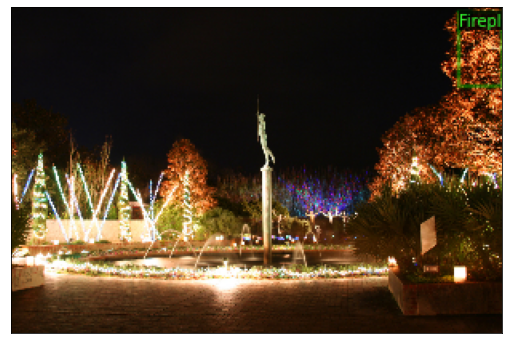

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Try default
from detectron2.engine import DefaultPredictor
cfg = get_cfg()
cfg.merge_from_file("output/config.yaml")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.2
# cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
n = 1
for d in random.sample(val_img_dicts, n):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]),
                            scale=0.3)
    #print(img)
    outputs = predictor(img)
    instances = outputs["instances"]
    print(instances[:5])
#     print(outputs["instances"].scores.max())
#     print([k for k, v in outputs.items()])
    vis = visualizer.draw_instance_predictions(instances[:1].to("cpu"))
    #vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(vis.get_image()) #[:, :, ::-1]) # don't need to reverse the pixels
    plt.xticks([])
    plt.yticks([])
    plt.show()

[02/02 01:02:52 fvcore.common.checkpoint]: [Checkpointer] Loading from output/model_final.pth ...
Instances(num_instances=5, image_height=683, image_width=1024, fields=[pred_boxes: Boxes(tensor([[278.7347,  16.0554, 910.4933, 650.2844],
        [243.7891,   5.0448, 923.7532, 637.3948],
        [322.9412, 215.5374, 906.7045, 485.1418],
        [277.5273,  17.8987, 906.6030, 645.7810],
        [652.6381, 260.1192, 906.8659, 385.3513]], device='cuda:0')), scores: tensor([0.8459, 0.3164, 0.2929, 0.2624, 0.2075], device='cuda:0'), pred_classes: tensor([27, 17, 17, 22, 17], device='cuda:0')])


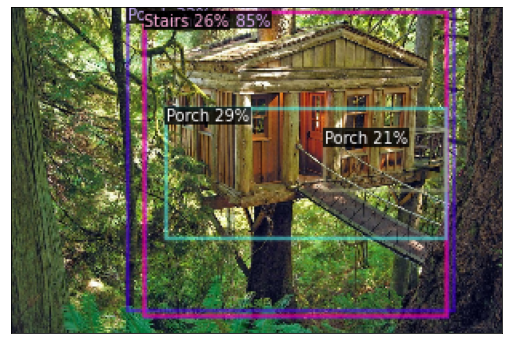

In [ ]:
# Try trained model
from detectron2.engine import DefaultPredictor
cfg = get_cfg()
cfg.merge_from_file("output/config.yaml")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.2
# cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = "output/model_final.pth"

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
n = 1
for d in random.sample(val_img_dicts, n):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]),
                            scale=0.3)
    #print(img)
    outputs = predictor(img)
    instances = outputs["instances"]
    print(instances[:5])
#     print(outputs["instances"].scores.max())
#     print([k for k, v in outputs.items()])
    vis = visualizer.draw_instance_predictions(instances[:5].to("cpu"))
    #vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(vis.get_image()) #[:, :, ::-1]) # don't need to reverse the pixels
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# try custom images
# Try trained model
from detectron2.engine import DefaultPredictor
cfg = get_cfg()
cfg.merge_from_file("output/config.yaml")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.2
# cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = "output/model_final.pth"

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
n = 1
file_path = "custom_images"
#for d in random.sample(os.listdir(file_path), n):
for d in os.listdir(file_path):
    img = cv2.imread(file_path+"/"+d)
    visualizer = Visualizer(img[...,::-1],
                            metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]),
                            scale=0.1)
    #print(img)
    outputs = predictor(img)
    instances = outputs["instances"]
    print(instances[:5])
#     print(outputs["instances"].scores.max())
#     print([k for k, v in outputs.items()])
    vis = visualizer.draw_instance_predictions(instances[:5].to("cpu"))
    #vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(20, 20))
    plt.imshow(vis.get_image()) #[:, :, ::-1]) # don't need to reverse the pixels
    plt.xticks([])
    plt.yticks([])
    plt.savefig("custom_preds/pred_"+d)
    plt.show()

In [ ]:
plt.savefig("kitchen.jpg")

<Figure size 432x288 with 0 Axes>

In [ ]:
img = random.sample(os.listdir(file_path), 1)
img

['IMG_6445.jpeg']

In [ ]:
import os
os.listdir("custom_images")

['.ipynb_checkpoints',
 'coffeemaker.jpeg',
 'coffeemaker.jpg',
 'airbnb-amenity-detection-workflow-large.png',
 'airbnb-amenity-detection-workflow-no-bg.png',
 'airbnb-article-cover.jpeg',
 'airbnb-demo-image.png',
 'IMG_6444.jpeg',
 'IMG_6445.jpeg',
 'IMG_6447.jpeg',
 'IMG_6448.jpeg',
 'IMG_6449.jpeg',
 'IMG_6450.jpeg',
 'IMG_6451.jpeg',
 'IMG_6453.jpeg',
 'IMG_6454.jpeg',
 'IMG_6455.jpeg']

In [ ]:
cfg.merge_from_file("output/config.yaml")

In [ ]:
cfg.MODEL.RETINANET

CfgNode({'NUM_CLASSES': 30, 'IN_FEATURES': ['p3', 'p4', 'p5', 'p6', 'p7'], 'NUM_CONVS': 4, 'IOU_THRESHOLDS': [0.4, 0.5], 'IOU_LABELS': [0, -1, 1], 'PRIOR_PROB': 0.01, 'SCORE_THRESH_TEST': 0.05, 'TOPK_CANDIDATES_TEST': 1000, 'NMS_THRESH_TEST': 0.5, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 1.0), 'FOCAL_LOSS_GAMMA': 2.0, 'FOCAL_LOSS_ALPHA': 0.25, 'SMOOTH_L1_LOSS_BETA': 0.0})

In [ ]:
cfg = get_cfg()
cfg.merge_from_file("output/config.yaml")
#cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = "output/model_final.pth"

In [ ]:
def visualize_sample(data_dicts, metadata, n=1):
  """
  Show n random samples from data_dicts, label with metadata.
  """
  for d in random.sample(data_dicts, n):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=metadata, 
                            scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    
#     # Try plot with cv2 in Jupyter... (doesn't work)
#     cv2.imshow('image', vis.get_image()[:, :, ::-1])
#     cv2.waitKey(0) 
#     cv2.destroyWindow('image')
    
    # Try plot with matplotlib (works)
    plt.figure(figsize=(10, 6))
    plt.imshow(vis.get_image()) #[:, :, ::-1])
    plt.xticks([])
    plt.yticks([])
    plt.show()

## TODO - Draw predictions

In [ ]:
import detectron2
# Load in config file
loaded_cfg = get_cfg()
loaded_cfg = loaded_cfg.load_yaml_with_base(os.path.join(loaded_cfg.OUTPUT_DIR, "config.yaml"))
loaded_cfg = detectron2.config.CfgNode(loaded_cfg)
# loaded_cfg

In [ ]:
loaded_cfg["MODEL"]["ROI_HEADS"]["SCORE_THRESH_TEST"]

0.05

In [ ]:
from detectron2.engine import DefaultPredictor
# Setup predictor
loaded_cfg["MODEL"]["WEIGHTS"] = os.path.join(loaded_cfg["OUTPUT_DIR"], "model_final.pth")
loaded_cfg["MODEL"]["ROI_HEADS"]["SCORE_THRESH_TEST"] = 0.7   # set the testing threshold for this model
loaded_cfg["DATASETS"]["TEST"] = ("cmaker-bathtub-treehouse-validation", )
predictor = DefaultPredictor(loaded_cfg)

[02/02 01:09:13 fvcore.common.checkpoint]: [Checkpointer] Loading from ./output/model_final.pth ...


In [ ]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(val_img_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cmaker_bathtub_metadata, 
                   scale=0.5 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])